In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from plotnine import ggplot, aes, geom_point, labs, scale_color_brewer, scale_color_distiller, scale_fill_gradient, theme, element_text, ggsave
import pandas as pd
import xgboost as xgb
import Functions

In [5]:
train_size = 0.75
val_size = 0.10
test_size = 0.15

y_train, y_val, y_test, X_train, X_val, X_test = Functions.getSplittedData(['Charge', 'Mass', 'NumAtoms', 'FractionSP3', 'NumRotatableBonds', 'Length'], train_size, val_size, test_size)

In [4]:
print("Numbers of samples in the splits")
print(f"Train Groups: {len(y_train)}")
print(f"Validation Groups: {len(y_val)}")
print(f"Test Groups: {len(y_test)}")
print(f"Total: {len(y_test)+len(y_train)+len(y_val)}")

Numbers of samples in the splits
Train Groups: 108095
Validation Groups: 14405
Test Groups: 21613
Total: 144113


In [10]:
m1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
m1.fit(X_train, y_train.ravel())

y_pred = m1.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.00035143363453623156
Mean Absolute Error: 0.010859895633930847
R² Score: 0.9907428588275182


In [11]:
importances = m1.feature_importances_
feature_names = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

# Sort the features by importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
0,Charge,0.950901
1,Mass,0.032765
2,Length,0.011358
5,FractionSP3,0.003937
4,NumAtoms,0.000872
3,NumRotatableBonds,0.000166


In [12]:
m2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
features = ['Mass', 'Charge']
m2.fit(X_train[features], y_train.ravel())



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred2 = m2.predict(X_val[features])
mse2 = mean_squared_error(y_val, y_pred2)
r22 = r2_score(y_val, y_pred2)
mae2 = mean_absolute_error(y_val, y_pred2)

print(f"Mean Squared Error: {mse2}")
print(f"Mean Absolute Error: {mae2}")
print(f"R² Score: {r22}")

Mean Squared Error: 0.0003678721524368031
Mean Absolute Error: 0.011167166818879394
R² Score: 0.9903098505268961


In [22]:
m3 = XGBRegressor()
param_grid = {
    'n_estimators': [ 500, 900, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'max_leaves': [1, 2, 3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
}
grid_search = HalvingGridSearchCV(m3, param_grid, cv=5, scoring='r2', random_state=42)
grid_search.fit(X_train[features], y_train.ravel())
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'max_leaves': 3,
 'min_child_weight': 1,
 'n_estimators': 900,
 'subsample': 0.9}

In [23]:
y_pred_fin = grid_search.predict(X_test[features])
mse_fin = mean_squared_error(y_test, y_pred_fin)
mae_fin = mean_absolute_error(y_test, y_pred_fin)
r2_fin = r2_score(y_test, y_pred_fin)
print(f"Mean Squared Error: {mse_fin}")
print(f"Mean Absolute Error: {mae_fin}")
print(f"R² Score: {r2_fin}")

Mean Squared Error: 0.00038440556939594764
Mean Absolute Error: 0.01144548969855845
R² Score: 0.98990670539685


C:\Users\samue\PycharmProjects\PBL_Ion_Mobility\.venv\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\samue\PycharmProjects\PBL_Ion_Mobility\.venv\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: C:/Users/samue/OneDrive/Desktop/Ion mobility/XGB.png


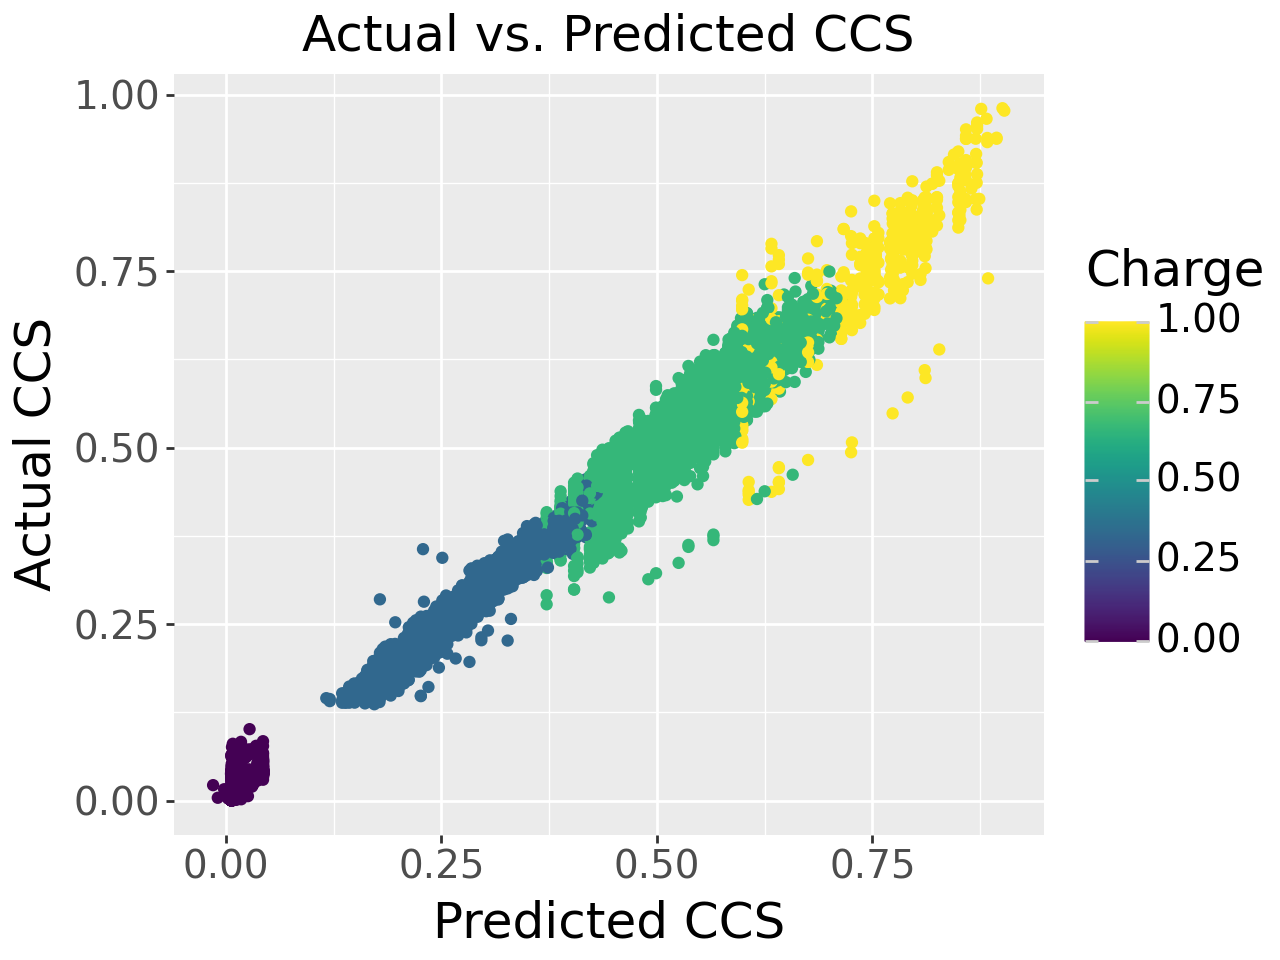

In [27]:
df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred_fin
df['CCS_actual'] = y_test
plot1 = (
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)
plot1.save(filename='C:/Users/samue/OneDrive/Desktop/Ion mobility/XGB.png', dpi=300)
plot1.show()

In [24]:
y_pred_val = grid_search.predict(X_val[features])
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print(f"Mean Squared Error: {mse_val}")
print(f"Mean Absolute Error: {mae_val}")
print(f"R² Score: {r2_val}")

Mean Squared Error: 0.00037430075167865854
Mean Absolute Error: 0.01128280755815914
R² Score: 0.9901405142856405


In [19]:
m_test = XGBRegressor(n_estimators=1200, learning_rate=0.05, max_depth=6, max_leaves=3, min_child_weight=2, subsample=0.8)
m_test.fit(X_train[features], y_train.ravel())
y_pred_test = m_test.predict(X_val[features])
mse_test = mean_squared_error(y_val, y_pred_test)
r2_test = r2_score(y_val, y_pred_test)
mae_test = mean_absolute_error(y_val, y_pred_test)
print(f"Mean Squared Error: {mse_test}")
print(f"Mean Absolute Error: {mae_test}")
print(f"R² Score: {r2_test}")


Mean Squared Error: 0.0003726413762336556
Mean Absolute Error: 0.011265227836479784
R² Score: 0.9901842240255259


In [20]:
y_pred_fin2 = m_test.predict(X_test[features])
mse_fin2 = mean_squared_error(y_test, y_pred_fin2)
r2_fin2 = r2_score(y_test, y_pred_fin2)
mae_fin2 = mean_absolute_error(y_test, y_pred_fin2)
print(f"Mean Squared Error: {mse_fin2}")
print(f"Mean Absolute Error: {mae_fin2}")
print(f"R² Score: {r2_fin2}")

Mean Squared Error: 0.00038336045492810437
Mean Absolute Error: 0.011439113822113874
R² Score: 0.9899341468520676


In [ ]:
{'learning_rate': 0.05,
 'max_depth': 5,
 'max_leaves': 3,
 'min_child_weight': 2,
 'n_estimators': 1000,
 'subsample': 0.8}